In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import gmean
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from src.config import get_interim_dir
from src.models.outliers import logratio_outlier_detection
from sklearn.covariance import EmpiricalCovariance
from src.visualization.plots import biplot, screeplot, loadingsplot

### Comparing outlier "scores" between screens.

- Perform PCA using only non-targetting controls. Project barcodes onto this space. Calculate mahalanobis distances. Compare rankings to previously ranked genes. 

In [3]:
FILTER_COUNT = 700
subscreen_aliases = ["MBsub1", "MBsub2", "MBsub3"]

aliases = ["MB01", "MB02"]

data = {}
for alias in aliases:
    genes_d_norm = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.{}.pkl".format(alias, FILTER_COUNT))
    data[alias] = genes_d_norm

for alias in subscreen_aliases:
    genes_d_norm = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.{}.full.pkl".format(alias, FILTER_COUNT))
    data[alias] = genes_d_norm
data = pd.concat(list(data.values()))
d_norm = data.div(data.sum(axis=1), axis=0)
d_norm.head()

lumc_category                               Deletion 0bp microhomology  \
Target Alias Gene          Barcode                                       
T1     MB01  0610009B22Rik 0610009B22Rik-1                    0.096128   
                           0610009B22Rik-2                    0.098854   
                           0610009B22Rik-3                    0.097005   
                           0610009B22Rik-4                    0.081714   
                           0610009B22Rik-5                    0.073362   

lumc_category                               Deletion 1bp microhomology  \
Target Alias Gene          Barcode                                       
T1     MB01  0610009B22Rik 0610009B22Rik-1                    0.129951   
                           0610009B22Rik-2                    0.166905   
                           0610009B22Rik-3                    0.116970   
                           0610009B22Rik-4                    0.112324   
                           0610009B22Rik-5                    0.151432   

lumc_category                               Deletion 2bp microhomology  \
Target Alias Gene          Barcode                                       
T1     MB01  0610009B22Rik 0610009B22Rik-1                    0.147308   
                           0610009B22Rik-2                    0.127507   
                           0610009B22Rik-3                    0.185052   
                           0610009B22Rik-4                    0.173277   
                           0610009B22Rik-5                    0.148293   

lumc_category                               Deletion with insertion  \
Target Alias Gene          Barcode                                    
T1     MB01  0610009B22Rik 0610009B22Rik-1                 0.085002   
                           0610009B22Rik-2                 0.079513   
                           0610009B22Rik-3                 0.078065   
                           0610009B22Rik-4                 0.068139   
                           0610009B22Rik-5                 0.094155   

lumc_category                               Homology Directed Repair  \
Target Alias Gene          Barcode                                     
T1     MB01  0610009B22Rik 0610009B22Rik-1                  0.242101   
                           0610009B22Rik-2                  0.183739   
                           0610009B22Rik-3                  0.164832   
                           0610009B22Rik-4                  0.188714   
                           0610009B22Rik-5                  0.166732   

lumc_category                               Any Insertion  \
Target Alias Gene          Barcode                          
T1     MB01  0610009B22Rik 0610009B22Rik-1       0.097908   
                           0610009B22Rik-2       0.101719   
                           0610009B22Rik-3       0.085999   
                           0610009B22Rik-4       0.131488   
                           0610009B22Rik-5       0.112985   

lumc_category                               Deletion 3+bp microhomology  
Target Alias Gene          Barcode                                       
T1     MB01  0610009B22Rik 0610009B22Rik-1                     0.201602  
                           0610009B22Rik-2                     0.241762  
                           0610009B22Rik-3                     0.272076  
                           0610009B22Rik-4                     0.244344  
                           0610009B22Rik-5                     0.253040

In [4]:
idx = pd.IndexSlice
non_targeting = "NonTargeting"
subscreen_rep = "MBsub3"
subs_d_norm = d_norm.loc[idx[:,subscreen_rep,:,:]]

Checking for zero values

In [5]:
print("Number of zero counts is", int((subs_d_norm == 0).any().any()))
print("No imputation needed")

Number of zero counts is 0
No imputation needed


In previous work, we took geometric average across replicates of the same target site. This was due to the noisy data.

We do not need to worry so much about that here because there is almost perfect agreement between the subscreen replicates. See `validation_analysis/1.gene_set_comparison.ipynb`

Doing PCA on nontargeting data. The nontargeting controls do not need to be aggregated.

In [6]:
nontarget_d_norm = subs_d_norm.loc[subs_d_norm.index.get_level_values("Gene") == non_targeting]
nontarget_d_norm = nontarget_d_norm.droplevel("Gene", axis=0)
nontarget_d_norm.index = nontarget_d_norm.index.set_names(["Target", "Gene"])
nontarget_d_norm.head(n=1)

,lumc_category,Deletion 0bp microhomology,Deletion 1bp microhomology,Deletion 2bp microhomology,Deletion with insertion,Homology Directed Repair,Any Insertion,Deletion 3+bp microhomology
Target,Gene,,,,,,,
T1,NonTargeting-0001,0.104083,0.120763,0.184689,0.098856,0.102264,0.096146,0.293198


We need to aggregate the gRNA-wise profiles to gene-wise profiles

In [7]:
genes_d_norm = subs_d_norm.loc[subs_d_norm.index.get_level_values("Gene") != non_targeting]
columns = genes_d_norm.columns

genes_d_norm = genes_d_norm.groupby(["Target", "Gene"]).apply(gmean)
genes_d_norm = pd.DataFrame(genes_d_norm.values.tolist(), index=genes_d_norm.index, columns=columns)
genes_d_norm = genes_d_norm.div(genes_d_norm.sum(axis=1), axis=0)
genes_d_norm.columns = columns

genes_d_norm.head(n=3)

lumc_category         Deletion 0bp microhomology  Deletion 1bp microhomology  \
Target Gene                                                                    
T1     1700025G04Rik                    0.099599                    0.127145   
       1700123O20Rik                    0.100368                    0.122331   
       1810037I17Rik                    0.103230                    0.134973   

lumc_category         Deletion 2bp microhomology  Deletion with insertion  \
Target Gene                                                                 
T1     1700025G04Rik                    0.179179                 0.097156   
       1700123O20Rik                    0.185017                 0.099376   
       1810037I17Rik                    0.182044                 0.099194   

lumc_category         Homology Directed Repair  Any Insertion  \
Target Gene                                                     
T1     1700025G04Rik                  0.105717       0.094734   
       1700123O20Rik                  0.099814       0.095843   
       1810037I17Rik                  0.091113       0.103881   

lumc_category         Deletion 3+bp microhomology  
Target Gene                                        
T1     1700025G04Rik                     0.296471  
       1700123O20Rik                     0.297251  
       1810037I17Rik                     0.285567

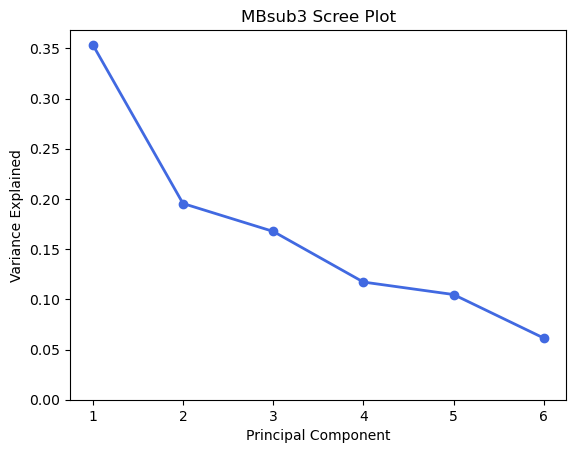

<Figure size 900x600 with 0 Axes>

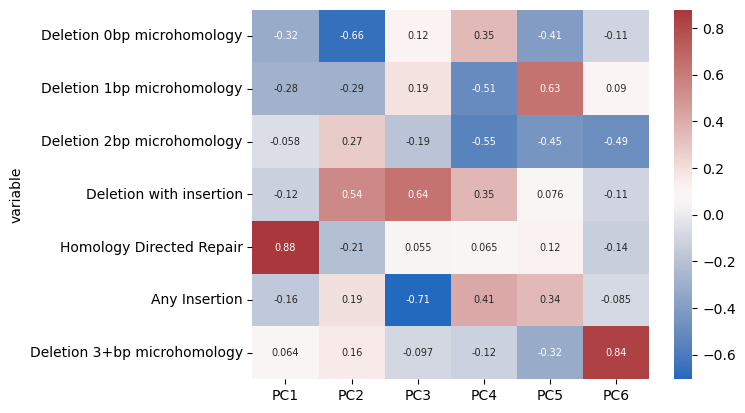

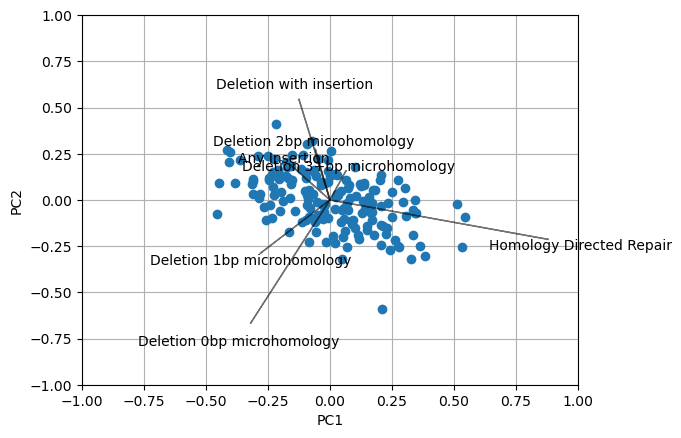

In [8]:
results = {}

pca_scores, loadings, explained_variance_ratio, distances, pvalues, transform_data, transform_data_distances, transform_data_pvalues = \
    logratio_outlier_detection(nontarget_d_norm, EmpiricalCovariance(), transform_data = genes_d_norm)
results = pca_scores, loadings, explained_variance_ratio, distances, pvalues

fig, ax = plt.subplots()
screeplot(explained_variance_ratio, ax, subscreen_rep)
plt.show()

plt.figure(figsize=(9, 6))
loadings_df, _ = loadingsplot(loadings, nontarget_d_norm.columns.to_list())
plt.show()

#Call the function. Use only the 2 PCs.
pcs_to_analyse = [0, 1]
biplot(pca_scores[:,pcs_to_analyse], loadings_df.iloc[:,pcs_to_analyse].values, \
       labels=loadings_df.index, components=loadings_df.iloc[:,pcs_to_analyse].columns)
plt.show()

If we compare the loadings plots to the old screen, we can see that the DELINS feature carries much less variance than it did previously. This is probably indicative of a higher quality screen where that feature is no longer capturing mostly noise.

Rank the genes according to their scores

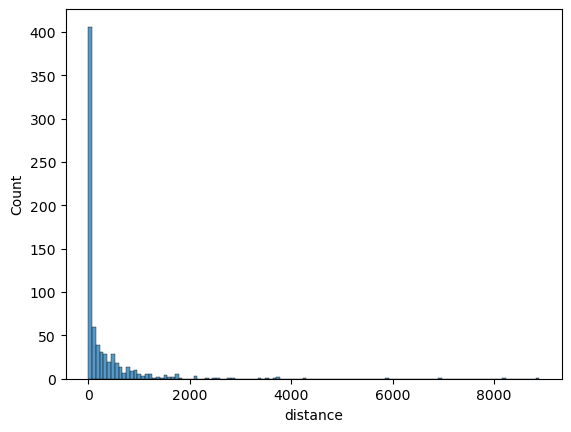

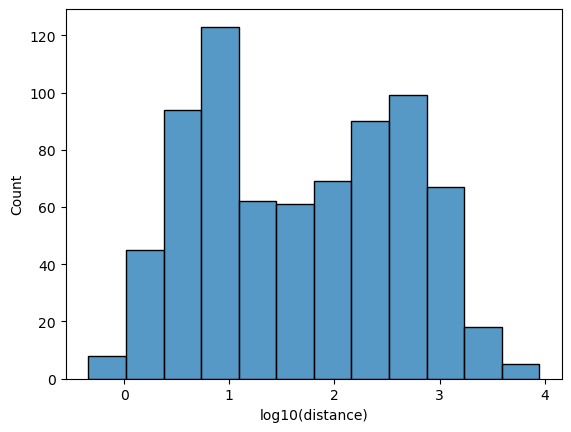

In [15]:
transform_data_distances = pd.Series(transform_data_distances, index=genes_d_norm.index.get_level_values("Gene"))
new_T1_scores = transform_data_distances.sort_values(ascending=False)
sns.histplot(new_T1_scores)
plt.xlabel("distance")
plt.show()

sns.histplot(np.log10(new_T1_scores))
plt.xlabel("log10(distance)")
plt.show()

Load T1 rankings from original screen

Pearson's correlation between T1 scores: 0.49
Spearman's correlation between T1 scores: 0.44


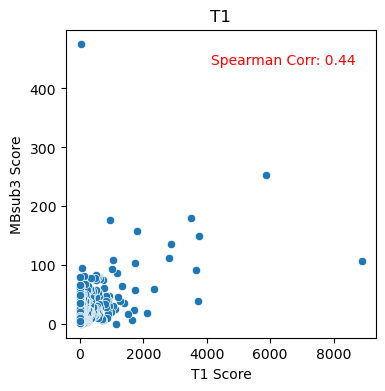

Pearson's correlation between T2 scores: 0.60
Spearman's correlation between T2 scores: 0.65


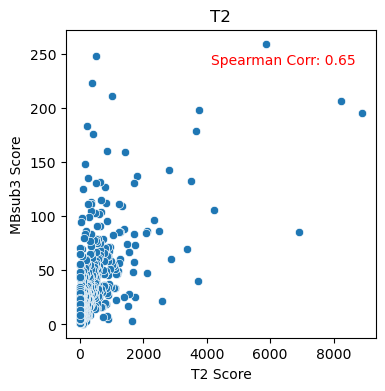

Pearson's correlation between T3 scores: 0.49
Spearman's correlation between T3 scores: 0.70


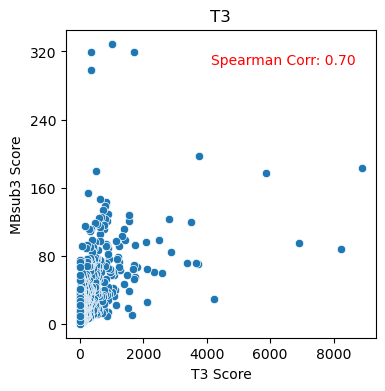

Pearson's correlation between Overall scores: 0.58
Spearman's correlation between Overall scores: 0.71


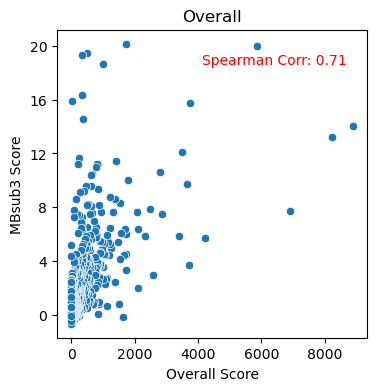

In [10]:
for score in ["T1", "T2", "T3", "Overall"]:
    final_gene_list = pd.read_csv("../../outlier_detection/artifacts/final_gene_list.tsv", sep="\t").iloc[2:]
    orig_scores = final_gene_list.rename(columns={"Sample": "Gene"}).set_index("Gene")[score].astype(float).sort_values(ascending=False)

    scores_df = pd.concat([new_T1_scores, orig_scores], axis=1, keys={"new", "old"}).dropna()

    p_corr = scores_df.corr(method="pearson").iloc[0,1]
    s_corr = scores_df.corr(method="spearman").iloc[0,1]

    print("Pearson's correlation between {} scores: {:.2f}".format(score, p_corr))
    print("Spearman's correlation between {} scores: {:.2f}".format(score, s_corr))

    fig, ax = plt.subplots(figsize=(4, 4))
    sns.scatterplot(data=scores_df, x="old", y="new", ax=ax)
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    plt.title(score)
    plt.ylabel(subscreen_rep + " Score")
    plt.xlabel(score + " Score")

    plt.text(0.7, 0.9, 'Spearman Corr: {:.2f}'.format(s_corr),
        color='red',
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes)
    plt.show()

In [11]:
scores_df.sort_values(by="new", ascending=False)

,old,new
Gene,,
Xrcc5,1716.875703,20.137448
H2ax,5863.789296,19.940038
Mad2l2,495.118781,19.436670
Atp2a2,358.511612,19.317264
Xrcc6,1019.351415,18.628755
...,...,...
Eme1,14.019434,-0.477697
Parp2,3.929890,-0.491118
Zbtb16,3.612284,-0.494471
